# dHybridR Example Notebook

#### Here we provide an example of what a typical analysis notebook will look like when computing velocity space signatures and generating MLA algo data will look like

In [1]:
import lib.analysis as anl 
import lib.array_ops as ao
import lib.data_h5 as dh5
import lib.data_netcdf4 as dnc
import lib.fpc as fpc
import lib.frametransform as ft
import lib.metadata as md

import lib.plot.oned as plt1d
import lib.plot.twod as plt2d
import lib.plot.debug as pltdebug
import lib.plot.fourier as pltfr
import lib.plot.resultsmanager as rsltmng
import lib.plot.velspace as pltvv

import os
import math
import numpy as np

In [2]:
#block to reload modules. Call this block after editing libraries
import importlib
importlib.reload(anl)
importlib.reload(ao)
importlib.reload(dh5)
importlib.reload(dnc)
importlib.reload(fpc)
importlib.reload(ft)
importlib.reload(md)
importlib.reload(plt1d)
importlib.reload(plt2d)
importlib.reload(pltdebug)
importlib.reload(pltfr)
importlib.reload(rsltmng)
importlib.reload(pltvv)

<module 'lib.plot.velspace' from '/Users/collbrown/Documents/OneDrive - University of Iowa/Research/DHybridR/analysistools/dHybridRAnalysis/lib/plot/velspace.py'>

### Load Analysis Input

In [3]:
path,resultsdir,vmax,dv,numframe,dx,xlim,ylim,zlim = anl.analysis_input()
path_particles = path+"Output/Raw/Sp01/raw_sp01_{:08d}.h5"

In [4]:
print(path,vmax,dv,numframe,dx,xlim,ylim,zlim)

M06_th45/ 15.0 0.5 2000 0.5 [15.0, 30.0] [0.0, 12.0] [0.0, 12.0]


### Load data

In [5]:
#load fields
dfields = dh5.field_loader(path=path,num=numframe)

#load flow data
dflow = dh5.flow_loader(path=path,num=numframe)

In [6]:
dfields.keys()

dict_keys(['bx', 'bx_xx', 'bx_yy', 'bx_zz', 'by', 'by_xx', 'by_yy', 'by_zz', 'bz', 'bz_xx', 'bz_yy', 'bz_zz', 'ex', 'ex_xx', 'ex_yy', 'ex_zz', 'ey', 'ey_xx', 'ey_yy', 'ey_zz', 'ez', 'ez_xx', 'ez_yy', 'ez_zz', 'Vframe_relative_to_sim'])

In [7]:
dfields['Vframe_relative_to_sim']

0.0

In [8]:
import time
start = time.time()
dparticles = dh5.read_box_of_particles(path_particles, numframe, xlim[0], xlim[1], ylim[0], ylim[1], zlim[0], zlim[1])
end = time.time()
print("Time consumed in loading: ",end - start)


Time consumed in loading:  579.2306530475616


In [9]:
import sys
sizetotal = sys.getsizeof(dparticles)
sizetotal /= 1073741824 #convert to mb
    
print('size of data: ' + str(sizetotal) + ' gb')

size of data: 3.427267074584961e-07 gb


### Plot fields, particle dist function, and flow
#### used as a sanity check on the data

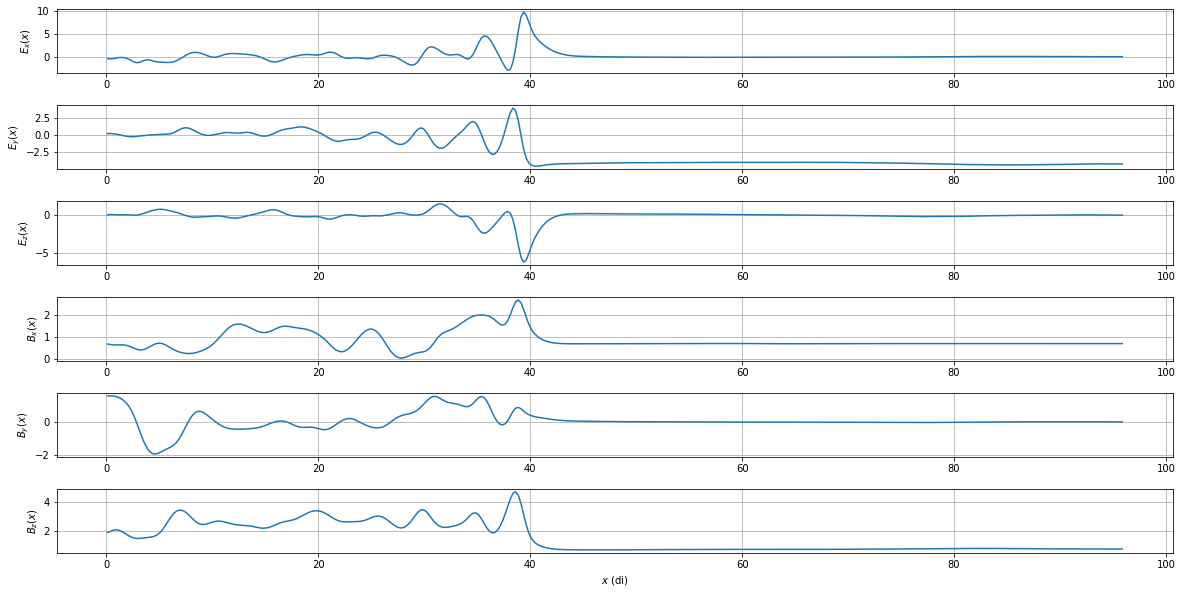

In [10]:
plt1d.plot_all_fields(dfields, axis='_xx', xxindex = 0, yyindex = 0, zzindex = 0)

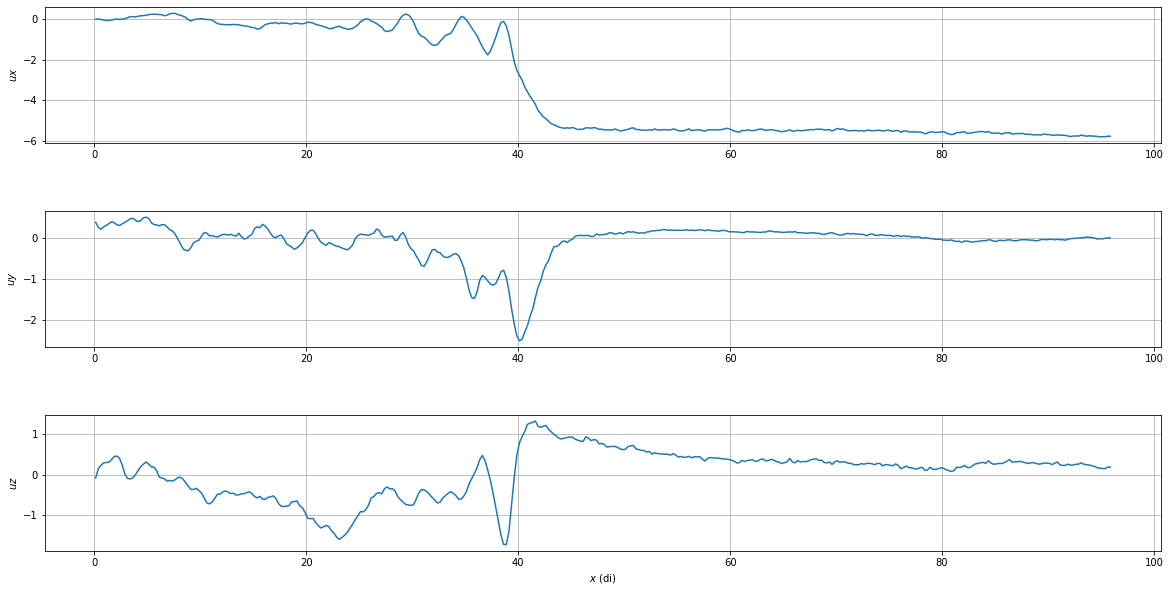

In [11]:
plt1d.plot_all_flow(dflow, axis='_xx', xxindex = 0, yyindex = 0, zzindex = 0)

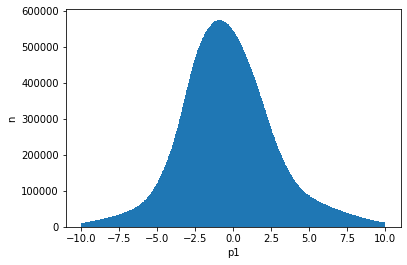

<Figure size 432x288 with 0 Axes>

In [12]:
pltdebug.plot_1d_dist(dparticles, 'p1', 10., xlim[0], xlim[1], ylim[0], ylim[1])

### Compute Shock Vel and Lorentz transform fields

In [13]:
all_dfields = dh5.all_dfield_loader(path=path, verbose=False)


In [14]:
vshock, xshockvals = ft.shock_from_ex_cross(all_dfields)

Warning, using dt = 0.01 Omega^-1... TODO: automate loading this...


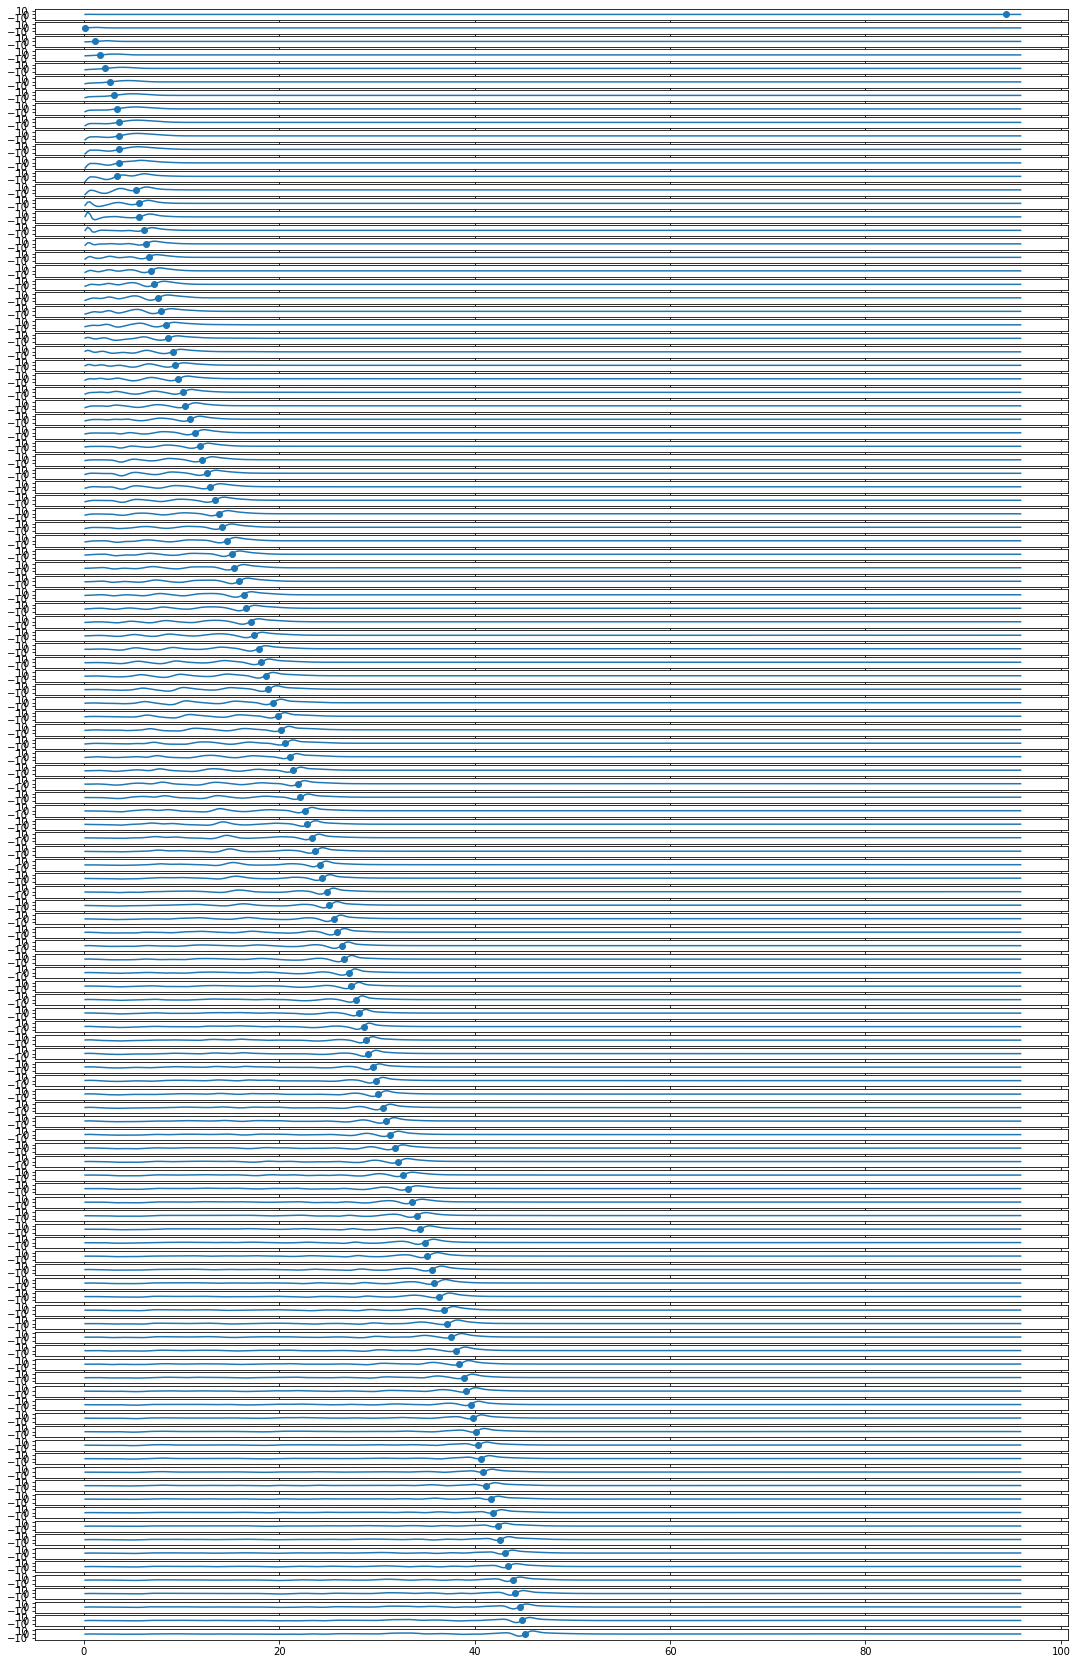

In [15]:
plt1d.time_stack_line_plot(all_dfields,'ex',pts = xshockvals)

In [16]:
#Lorentz transform fields
dfields = ft.lorentz_transform_vx(dfields,vshock)
_fields = []
for k in range(0,len(all_dfields['dfields'])):
    _fields.append(ft.lorentz_transform_vx(all_dfields['dfields'][k],vshock))
all_dfields['dfields'] = _fields

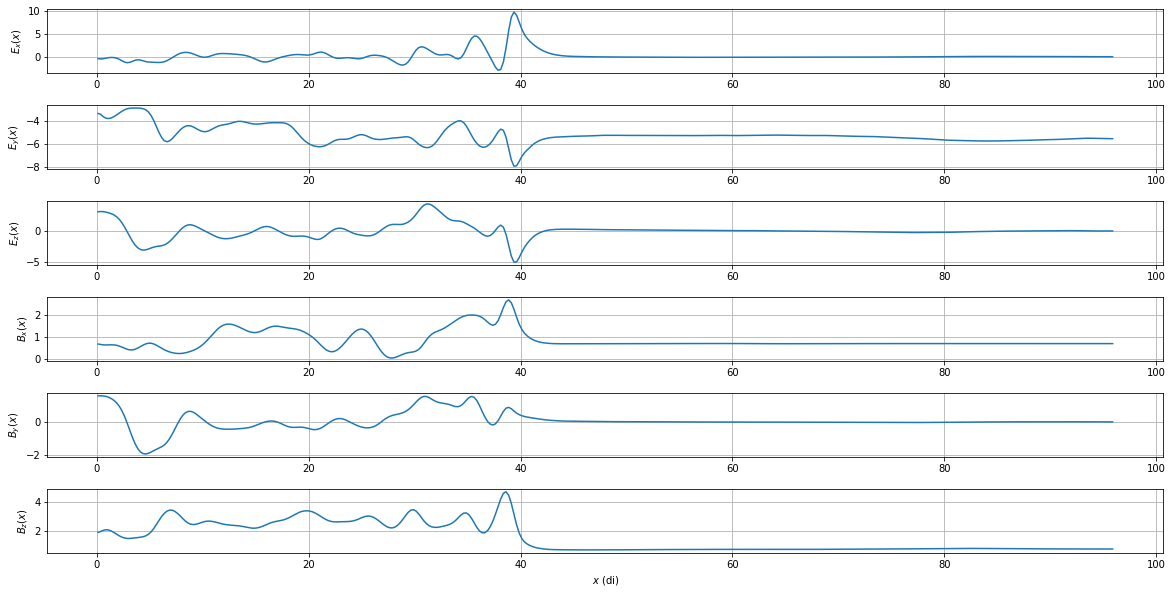

In [17]:
plt1d.plot_all_fields(dfields, axis='_xx', xxindex = 0, yyindex = 0, zzindex = 0)

### Determine where shock is
#### want to figure out the x range of the shock and assign correct metadata values

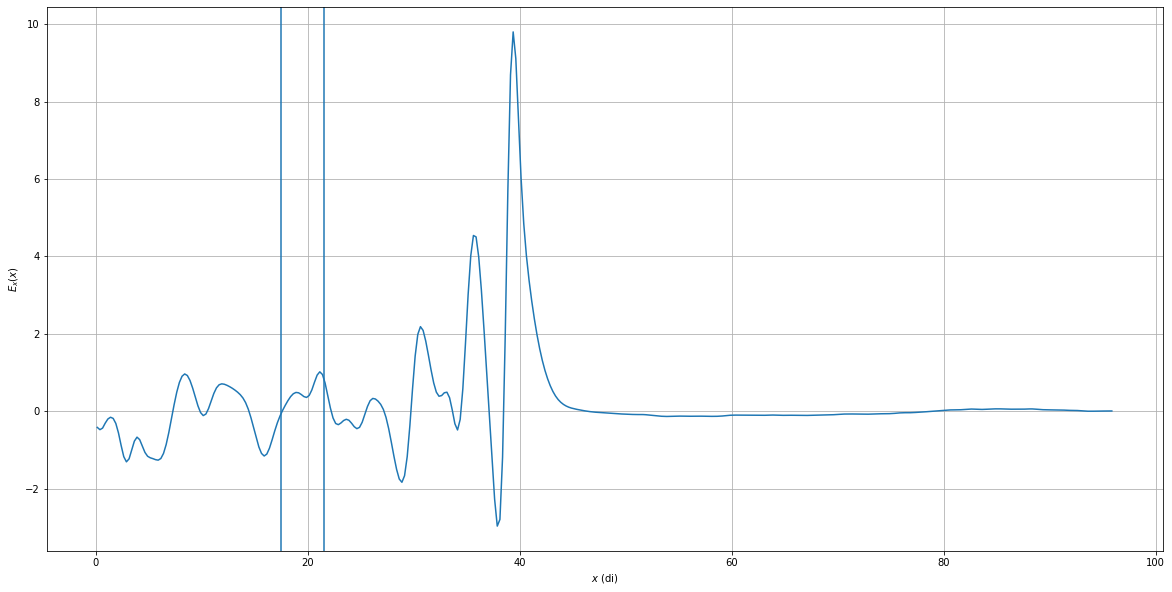

In [18]:
#Use this block to determine start and end val
#by editing startval and endval and replotting until bounds are correct
startval = 17.5#lower bound for metadata = 1 (di)
endval = 21.5 #upper bound for metadata = 1 (di)

yyindex = 0
zzindex = 0
plt1d.plot_field(dfields, 'ex', axis='_xx', yyindex = yyindex, zzindex = zzindex, axvx1 = startval, axvx2 = endval)

In [19]:
xlim

[15.0, 30.0]

In [20]:
metadata = md.build_metadata(xlim,dx, startval, endval)

In [21]:
metadata

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

### Test super plot

In [ ]:
x1 = xlim[0]
x2 = xlim[1]
y1 = ylim[0]
y2 = ylim[1] 
z1 = zlim[0] 
z2 = zlim[1]

vx, vy, vz, totalPtcl, totalFieldpts, Hist, CEx = fpc.compute_hist_and_cor(vmax, dv, x1, x2, y1, y2, z1, z2, dparticles, dfields, vshock, 'ex', 'x')
vx, vy, vz, totalPtcl, totalFieldpts, Hist, CEy = fpc.compute_hist_and_cor(vmax, dv, x1, x2, y1, y2, z1, z2, dparticles, dfields, vshock, 'ey', 'y')
vx, vy, vz, totalPtcl, totalFieldpts, Hist, CEz = fpc.compute_hist_and_cor(vmax, dv, x1, x2, y1, y2, z1, z2, dparticles, dfields, vshock, 'ez', 'z')

In [ ]:
totalPtcl

In [ ]:
CEx = CEx_in[0]
CEy = CEy_in[0]
CEz = CEz_in[0]
Hist = Hist_in[0]
vx = vx_in
vy = vy_in
vz = vz_in

#Project onto correct axes
H_xy = ao.array_3d_to_2d(Hist,'xy')
H_xz = ao.array_3d_to_2d(Hist,'xz')
H_yz = ao.array_3d_to_2d(Hist,'yz')
CEx_xy = ao.array_3d_to_2d(CEx,'xy')
CEx_xz = ao.array_3d_to_2d(CEx,'xz')
CEx_yz = ao.array_3d_to_2d(CEx,'yz')
CEy_xy = ao.array_3d_to_2d(CEy,'xy')
CEy_xz = ao.array_3d_to_2d(CEy,'xz')
CEy_yz = ao.array_3d_to_2d(CEy,'yz')
CEz_xy = ao.array_3d_to_2d(CEz,'xy')
CEz_xz = ao.array_3d_to_2d(CEz,'xz')
CEz_yz = ao.array_3d_to_2d(CEz,'yz')

In [ ]:

vx_xy, vy_xy = ao.mesh_3d_to_2d(vx,vy,vz,'xy')
pltvv.plot_velsig(vx_xy,vy_xy,vmax,CEx_xy,'ex',flnm = '',ttl='')

In [ ]:
pltvv.plot_cor_and_dist_supergrid(vx, vy, vz, vmax,
                                H_xy, H_xz, H_yz,
                                CEx_xy,CEx_xz, CEx_yz,
                                CEy_xy,CEy_xz, CEy_yz,
                                CEz_xy,CEz_xz, CEz_yz)

### Perform FPC analysis

In [ ]:
#Compute correlation and distribution
#Note: CEx,CEy, CEz, vx, vy, vz are returned in their '3d' (i.e. 3d array) form.
#must project onto 2d plane to plot
CEx, CEy, CEz, x, Hist, vx, vy, vz = fpc.compute_correlation_over_x(dfields, dparticles, vmax, dv, dx, vshock,xlim=xlim,ylim=ylim,zlim=zlim)

### Make superplot gif

In [ ]:
pltvv.make_superplot_gif(vx, vy, vz, vmax, Hist, CEx, CEy, CEz, x, 'superplotGraphs', 'superplottest.gif')

In [ ]:
rsltmng.make_gif_from_folder('superplotGraphs','superplottest.gif')

### Convert to previous '2v FPC' formatting

In [ ]:
#for now, we just do CEx_xy CEy_xy
#Here we convert to the previous 2d format
#TODO: this takes a minute, probably only want to project once 
CEx_2v = []
CEy_2v = []
CEz_2v = []
for i in range(0,len(CEx)):
    CEx_xy = ao.array_3d_to_2d(CEx[i],'xy')
    CEy_xy = ao.array_3d_to_2d(CEy[i],'xy')
    CEz_xy = ao.array_3d_to_2d(CEz[i],'xy')
    CEx_2v.append(CEx_xy)
    CEy_2v.append(CEy_xy)
    CEz_2v.append(CEz_xy)
    
vx_xy, vy_xy = ao.mesh_3d_to_2d(vx,vy,vz,'xy')
x_out = x

#### Compute energization from correlations

In [ ]:
#TODO: project onto 2d plane and handle different projections net energization
#Also note, technically, we can project in this order, to compute energization,
#but it is a little confusing to follow
enerCEx_out = anl.compute_energization_over_x(CEx_2v,dv)
enerCEy_out = anl.compute_energization_over_x(CEy_2v,dv)
enerCEz_out = anl.compute_energization_over_x(CEz_2v,dv)

### Calculate relevant simulation parameters and save as netcdf4

In [ ]:
inputdict = dnc.parse_input_file(path)

In [ ]:
params = dnc.build_params(inputdict,numframe)

In [ ]:
inputdict

In [ ]:
params

In [ ]:
metadata

In [14]:
savenewfmt = True
flnm = '3Vtest1.nc'

In [ ]:
if(savenewfmt):
    try:
        dnc.save3Vdata(Hist, CEx, CEy, CEz, vx, vy, vz, x_out, enerCEx_out, enerCEy_out, enerCEz_out, dfields['Vframe_relative_to_sim'], metadata_out = metadata, params = params, filename = flnm)
    except:
        os.system('rm '+flnm)
        dnc.save3Vdata(Hist, CEx, CEy, CEz, vx, vy, vz, x_out, enerCEx_out, enerCEy_out, enerCEz_out, dfields['Vframe_relative_to_sim'], metadata_out = metadata, params = params, filename = flnm)
else:
    flnm = '2Vtest.nc'
    try:
        dnc.savedata(CEx_2v, CEy_2v, vx_xy, vy_xy, x_out, enerCEx_out, enerCEy_out, dfields['Vframe_relative_to_sim'], metadata_out = metadata, params = params, filename = flnm)
    except:
        os.system('rm '+flnm)
        dnc.savedata(CEx_2v, CEy_2v, vx_xy, vy_xy, x_out, enerCEx_out, enerCEy_out, dfields['Vframe_relative_to_sim'], metadata_out = metadata, params = params, filename = flnm)

### Load netcdf4
#### Saves time if the correlation over x has already been computed

In [59]:
if(savenewfmt):
    Hist_in, CEx_in, CEy_in, CEz_in, vx_in, vy_in, vz_in, x_in, enerCEx_in, enerCEy_in, enerCEz_in, Vframe_relative_to_sim, metadata_in, params_in = dnc.load3Vnetcdf4(flnm)
else:
    CEx_in, CEy_in, vx_in, vy_in, x_in, enerCEx_in, enerCEy_in, Vframe_relative_to_sim, metadata_in, params_in = dnc.load_netcdf4(flnm)

### Perform sanity checks
#### E cross B gif

In [ ]:
dfields['bz_zz']

In [ ]:
CEx_xy

In [ ]:
CEx_xy = [ao.array_3d_to_2d(CEx[i],'xy') for i in range(0,len(CEx))]
vx_xy, vy_xy = ao.mesh_3d_to_2d(vx,vy,vz,'xy')
pltvv.make_velsig_gif_with_EcrossB(vx_xy, vy_xy, vmax, CEx_xy, 'ex', x_out, dx, dfields, 'CExExB', 'CExExB.gif', xlim = xlim, ylim = ylim, zlim = zlim)

In [ ]:
rsltmng.make_gif_from_folder('CExExB', 'CExExB.gif')

<img src="CExExB.gif" width="750" align="center">

In [ ]:
pltvv.make_velsig_gif_with_EcrossB(vx_in, vy_in, vmax, CEy_in, 'ex', x_out, dx, dfields, 'CEyExB', 'CEyExB.gif', xlim = xlim, ylim = ylim, zlim = zlim)

In [ ]:
rsltmng.make_gif_from_folder('CEyExB', 'CEyExB.gif')

<img src="CEyExB.gif" width="750" align="center">

##  Plot fields as a function of time

In [ ]:
#Plots Ex(x=xxpltpoint,y=0,z=0;t)
xxpltpoint = 20.0 #di
xxindex = ao.find_nearest(dfields['ex_xx'], xxpltpoint)
plt1d.plot_field_time(all_dfields, 'ex', xxindex = xxindex, yyindex = 0, zzindex = 0)

### Find maximum speed in each direction
#### Quick check to make sure our simulation is numerically stable (max speed should be less than 25)

In [ ]:
anl.get_abs_max_velocity(dparticles)

### Test making field pmesh

In [ ]:
xxindex = 164
plt2d.make_field_pmesh(dfields,'bz','yz',flnm = '',takeaxisaverage=False,xxindex=xxindex)

In [ ]:
plt2d.make_field_pmesh(dfields,'bz','xz',takeaxisaverage=False,yyindex = 0,xlimmin=35,xlimmax=45)

In [ ]:
xx = 40.0
xxindex = ao.find_nearest(dfields['ex_xx'], xx)
plt2d.compare_pmesh_fields_yz(dfields, flnm = '', ttl ='x (di): ' + str(dfields['ex_xx'][xxindex]), takeaxisaverage=False, xxindex=xxindex)

In [ ]:
plt2d.compare_pmesh_fields_yz_sweep(dfields,'pmeshsweep')

In [ ]:
rsltmng.make_gif_from_folder('pmeshsweep', 'pmeshsweep.gif')

### Estimate Ripple size

In [ ]:
plt1d.plot_stack_field_along_x(dfields,'bz','_yy',yyindex=0,zzindex=0)

In [ ]:
plt1d.plot_stack_field_along_x(dfields,'bz','_yy',yyindex=0,zzindex=0,xlow=35.,xhigh=45.)

### Test 2d fourier (WIP)

In [ ]:
startval = 39.
endval = 40.5
plt1d.plot_field(dfields, 'bz', axis='_xx', yyindex = yyindex, zzindex = zzindex, axvx1 = startval, axvx2 = endval)

In [ ]:
k0, k1, fieldpmesh, xplot, yplot = pltfr.plot_fft_norm(dfields,'bz','yz',plotlog = False,takeaxisaverage=False,xxindex=164)

### Test Energization vs J dot E (WIP)

In [ ]:
import matplotlib.pyplot as plt

JdotEarr = []
energizationCExArr = []
energizationCEyArr = []

npar = sanf.getnumparticlesinbox(dparticles, dfields['ex_xx'][0], dfields['ex_xx'][1], 
                                 dfields['ey_yy'][0], dfields['ey_yy'][1],
                                 dfields['ey_zz'][0], dfields['ey_zz'][1])

xsweep = 0.0
for i in range(0,len(dfields['ex_xx'])):
    JdotEarr.append(sanf.calc_JdotE(dfields ,dflow,xsweep, xsweep+dx, dfields['ey_yy'][0], dfields['ey_yy'][1],dfields['ey_zz'][0], dfields['ey_zz'][1]))
    
    
    
    energizationCExArr.append(af.compute_energization(CEx_out[i],dv)/npar)
    energizationCEyArr.append(af.compute_energization(CEy_out[i],dv)/npar)
    print(xsweep) #'quick progress bar'
    xsweep+=dx


In [ ]:
plt.figure()
plt.plot(x_out,JdotEarr,label='J dot E')
plt.plot(x_out,energizationCExArr,label='E(CEx(x; vy, vx))')
plt.plot(x_out,energizationCEyArr,label='E(CEy(x; vy, vx))')
plt.legend()
plt.show()

In [ ]:
plt.figure()
#plt.plot(x_out,JdotEarr,label='J dot E')
plt.plot(x_out,energizationCExArr,label='E(CEx(x; vy, vx))')
plt.plot(x_out,energizationCEyArr,label='E(CEy(x; vy, vx))')
plt.legend()
plt.show()

In [ ]:
dflowtransform = ft.transform_flow(dflow,vshock)
pltdebug.check_JiEi_vs_CEi(dfields,dflowtransform,dparticles,x_in,enerCEx_in,enerCEy_in,dx,xlim=xlim,ylim=ylim,zlim=zlim)

In [ ]:
dflowtransform['Vframe_relative_to_sim']

In [ ]:
vshock

In [ ]:
dfields['Vframe_relative_to_sim']

### Test averaging out shock event

In [ ]:
def remove_average_fields_over_yz(dfields):
    from copy import copy

    dfieldfluc = copy(dfields) #deep copy
    dfieldfluc['ex'] = dfields['ex']-dfields['ex'].mean(axis=(0,1))
    dfieldfluc['ey'] = dfields['ey']-dfields['ey'].mean(axis=(0,1))
    dfieldfluc['ez'] = dfields['ez']-dfields['ez'].mean(axis=(0,1))
    dfieldfluc['bx'] = dfields['bx']-dfields['bx'].mean(axis=(0,1))
    dfieldfluc['by'] = dfields['by']-dfields['by'].mean(axis=(0,1))
    dfieldfluc['bz'] = dfields['bz']-dfields['bz'].mean(axis=(0,1))
    
    return dfieldfluc
    

In [ ]:
dfieldfluc = remove_average_fields_over_yz(dfields)

In [ ]:
plt1d.plot_all_fields(dfieldfluc, axis='_xx', xxindex = 0, yyindex = 0, zzindex = 0)#,lowxlim=15,highxlim=25)

In [ ]:
plt1d.plot_all_fields(dfieldfluc, axis='_xx', xxindex = 0, yyindex = 0, zzindex = 0,lowxlim=35,highxlim=45)

In [ ]:
import matplotlib.pyplot as plt
def compare_fields(dfields1, dfields2, fieldkey, axis='_xx', xxindex = 0, yyindex = 0, zzindex = 0, axvx1 = float('nan'), axvx2 = float('nan'), flnm = ''):
    """
 
    """


    if(axis == '_zz'):
        fieldval1 = np.asarray([dfields1[fieldkey][i][yyindex][xxindex] for i in range(0,len(dfields1[fieldkey+axis]))])
        fieldval2 = np.asarray([dfields2[fieldkey][i][yyindex][xxindex] for i in range(0,len(dfields2[fieldkey+axis]))])
        xlbl = 'z'
    elif(axis == '_yy'):
        fieldval1 = np.asarray([dfields1[fieldkey][zzindex][i][xxindex] for i in range(0,len(dfields1[fieldkey+axis]))])
        fieldval2 = np.asarray([dfields2[fieldkey][zzindex][i][xxindex] for i in range(0,len(dfields2[fieldkey+axis]))])
        xlbl = 'y'
    elif(axis == '_xx'):
        fieldval1 = np.asarray([dfields1[fieldkey][zzindex][yyindex][i] for i in range(0,len(dfields1[fieldkey+axis]))])
        fieldval2 = np.asarray([dfields2[fieldkey][zzindex][yyindex][i] for i in range(0,len(dfields2[fieldkey+axis]))])
        xlbl = 'x'

    fieldcoord1 = np.asarray(dfields1[fieldkey+axis])
    fieldcoord2 = np.asarray(dfields2[fieldkey+axis])

    plt.figure(figsize=(20,10))
    plt.xlabel(xlbl)
    plt.ylabel(fieldkey)
    plt.plot(fieldcoord1,fieldval1)
    plt.plot(fieldcoord2,fieldval2)
    if(not(axvx1 != axvx1)): #if not nan
        plt.axvline(x=axvx1)
    if(not(axvx2 != axvx2)): #if not nan
        plt.axvline(x=axvx2)
    if(flnm == ''):
        plt.show()
    else:
        plt.savefig(flnm,format='png')
    plt.close()

In [ ]:
compare_fields(dfields, dfieldfluc, 'ex', axis='_xx', xxindex = 0, yyindex = 0, zzindex = 0, axvx1 = float('nan'), axvx2 = float('nan'), flnm = '')

In [ ]:
compare_fields(dfields, dfieldfluc, 'ey', axis='_xx', xxindex = 0, yyindex = 0, zzindex = 0, axvx1 = float('nan'), axvx2 = float('nan'), flnm = '')

In [ ]:
compare_fields(dfields, dfieldfluc, 'ez', axis='_xx', xxindex = 0, yyindex = 0, zzindex = 0, axvx1 = float('nan'), axvx2 = float('nan'), flnm = '')

In [ ]:
compare_fields(dfields, dfieldfluc, 'bx', axis='_xx', xxindex = 0, yyindex = 0, zzindex = 0, axvx1 = float('nan'), axvx2 = float('nan'), flnm = '')

In [ ]:
compare_fields(dfields, dfieldfluc, 'by', axis='_xx', xxindex = 0, yyindex = 0, zzindex = 0, axvx1 = float('nan'), axvx2 = float('nan'), flnm = '')

In [ ]:
compare_fields(dfields, dfieldfluc, 'bz', axis='_xx', xxindex = 0, yyindex = 0, zzindex = 0, axvx1 = float('nan'), axvx2 = float('nan'), flnm = '')

In [ ]:
plt2d.make_field_pmesh(dfieldfluc,'bz','xy',flnm = '',takeaxisaverage=False, xxindex=float('nan'), yyindex=float('nan'), zzindex=0, xlimmin=25,xlimmax=45)

In [ ]:
plt2d.make_field_pmesh(dfieldfluc,'bz','xz',flnm = '',takeaxisaverage=False, xxindex=float('nan'), yyindex=0, zzindex=float('nan'), xlimmin=25,xlimmax=45)

In [ ]:
plt2d.make_field_pmesh(dfields,'bz','xz',flnm = '',takeaxisaverage=False, xxindex=float('nan'), yyindex=0, zzindex=float('nan'), xlimmin=25,xlimmax=45)

In [ ]:
k0,fftdata = pltfr.plot1d_fft(dfieldfluc,'ex')

In [ ]:
k0,fftdata = pltfr.plot1d_fft(dfieldfluc,'ey')

In [ ]:
k0,fftdata = pltfr.plot1d_fft(dfieldfluc,'ez')

In [ ]:
k0,fftdata = pltfr.plot1d_fft(dfieldfluc,'bx')

In [ ]:
k0,fftdata = pltfr.plot1d_fft(dfieldfluc,'by')

In [ ]:
k0,fftdata = pltfr.plot1d_fft(dfieldfluc,'bz')

### Do fourier sweeps

In [ ]:
plt2d.make_field_pmesh(dfieldfluc,'bz','xy',flnm = '',takeaxisaverage=False, xxindex=float('nan'), yyindex=float('nan'), zzindex=0, xlimmin=25,xlimmax=45)

In [ ]:
pltfr.plot_fft_norm(dfields,'bz','yz',flnm = '',takeaxisaverage=False, xxindex=100, yyindex=float('nan'), zzindex=float('nan'), plotlog = False,xaxislim=2,yaxislim=2)

In [ ]:
xaxislim=5
yaxislim=5
pltfr.make_2dfourier_sweep(dfields,'bz','yz','fourierswptest',plotlog=False,xaxislim=xaxislim,yaxislim=yaxislim)

In [ ]:
rsltmng.make_gif_from_folder('fourierswptest', 'fourierswptest.gif')

### Compare FPCs

In [ ]:
pltdebug.plot_1d_dist(dparticles, 'x1', 35., xlim[0], xlim[1], ylim[0], ylim[1])

In [ ]:
dparticles

In [ ]:
print(xlim,ylim,zlim)

In [ ]:
x1 = 24.0
x2 = 27.0
y1 = ylim[0]
y2 = ylim[1] 
z1 = zlim[0] 
z2 = zlim[1]

In [ ]:
vx, vy, vz, totalPtcl, totalFieldpts, Hist, CEx = fpc.compute_hist_and_cor(vmax, dv, x1, x2, y1, y2, z1, z2, dparticles, dfields, vshock, 'ex', 'x')
vx, vy, vz, totalPtcl, totalFieldpts, Hist, CEy = fpc.compute_hist_and_cor(vmax, dv, x1, x2, y1, y2, z1, z2, dparticles, dfields, vshock, 'ey', 'y')
vx, vy, vz, totalPtcl, totalFieldpts, Hist, CEz = fpc.compute_hist_and_cor(vmax, dv, x1, x2, y1, y2, z1, z2, dparticles, dfields, vshock, 'ez', 'z')

In [ ]:
totalPtcl

In [ ]:
#Project onto correct axes
H_xy = ao.array_3d_to_2d(Hist,'xy')
H_xz = ao.array_3d_to_2d(Hist,'xz')
H_yz = ao.array_3d_to_2d(Hist,'yz')
CEx_xy = ao.array_3d_to_2d(CEx,'xy')
CEx_xz = ao.array_3d_to_2d(CEx,'xz')
CEx_yz = ao.array_3d_to_2d(CEx,'yz')
CEy_xy = ao.array_3d_to_2d(CEy,'xy')
CEy_xz = ao.array_3d_to_2d(CEy,'xz')
CEy_yz = ao.array_3d_to_2d(CEy,'yz')
CEz_xy = ao.array_3d_to_2d(CEz,'xy')
CEz_xz = ao.array_3d_to_2d(CEz,'xz')
CEz_yz = ao.array_3d_to_2d(CEz,'yz')

In [ ]:

vx_xy, vy_xy = ao.mesh_3d_to_2d(vx,vy,vz,'xy')
pltvv.plot_velsig(vx_xy,vy_xy,vmax,CEx_xy,'ex',flnm = '',ttl='')

In [ ]:
pltvv.plot_cor_and_dist_supergrid(vx, vy, vz, vmax,
                                H_xy, H_xz, H_yz,
                                CEx_xy,CEx_xz, CEx_yz,
                                CEy_xy,CEy_xz, CEy_yz,
                                CEz_xy,CEz_xz, CEz_yz)

### Above is with original fields. Below is average subtracted fields

In [ ]:
vx, vy, vz, totalPtcl, totalFieldpts, Hist, CEx = fpc.compute_hist_and_cor(vmax, dv, x1, x2, y1, y2, z1, z2, dparticles, dfieldfluc, vshock, 'ex', 'x')
vx, vy, vz, totalPtcl, totalFieldpts, Hist, CEy = fpc.compute_hist_and_cor(vmax, dv, x1, x2, y1, y2, z1, z2, dparticles, dfieldfluc, vshock, 'ey', 'y')
vx, vy, vz, totalPtcl, totalFieldpts, Hist, CEz = fpc.compute_hist_and_cor(vmax, dv, x1, x2, y1, y2, z1, z2, dparticles, dfieldfluc, vshock, 'ez', 'z')

In [ ]:
totalPtcl

In [ ]:
#Project onto correct axes
H_xy = ao.array_3d_to_2d(Hist,'xy')
H_xz = ao.array_3d_to_2d(Hist,'xz')
H_yz = ao.array_3d_to_2d(Hist,'yz')
CEx_xy = ao.array_3d_to_2d(CEx,'xy')
CEx_xz = ao.array_3d_to_2d(CEx,'xz')
CEx_yz = ao.array_3d_to_2d(CEx,'yz')
CEy_xy = ao.array_3d_to_2d(CEy,'xy')
CEy_xz = ao.array_3d_to_2d(CEy,'xz')
CEy_yz = ao.array_3d_to_2d(CEy,'yz')
CEz_xy = ao.array_3d_to_2d(CEz,'xy')
CEz_xz = ao.array_3d_to_2d(CEz,'xz')
CEz_yz = ao.array_3d_to_2d(CEz,'yz')

In [ ]:

vx_xy, vy_xy = ao.mesh_3d_to_2d(vx,vy,vz,'xy')
pltvv.plot_velsig(vx_xy,vy_xy,vmax,CEx_xy,'ex',flnm = '',ttl='')

In [ ]:
pltvv.plot_cor_and_dist_supergrid(vx, vy, vz, vmax,
                                H_xy, H_xz, H_yz,
                                CEx_xy,CEx_xz, CEx_yz,
                                CEy_xy,CEy_xz, CEy_yz,
                                CEz_xy,CEz_xz, CEz_yz)

### Make sweep gif for presentation

In [ ]:
plt1d.make_field_scan_gif(dfields, 'ex', 'scantest', axis='_xx')

In [ ]:
rsltmng.make_gif_from_folder('scantest', 'scantest.gif')

### Test log space distribution plot

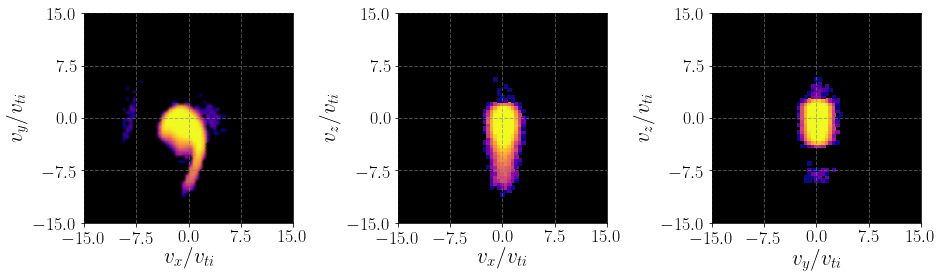

In [272]:
pltvv.dist_log_plot_3dir(vx_in, vy_in, vz_in, vmax, Hist_in[1], flnm = '',ttl='')

In [271]:
#block to reload modules. Call this block after editing libraries
import importlib
importlib.reload(anl)
importlib.reload(ao)
importlib.reload(dh5)
importlib.reload(dnc)
importlib.reload(fpc)
importlib.reload(ft)
importlib.reload(md)
importlib.reload(plt1d)
importlib.reload(plt2d)
importlib.reload(pltdebug)
importlib.reload(pltfr)
importlib.reload(rsltmng)
importlib.reload(pltvv)

<module 'lib.plot.velspace' from '/Users/collbrown/Documents/OneDrive - University of Iowa/Research/DHybridR/analysistools/dHybridRAnalysis/lib/plot/velspace.py'>

In [256]:
Hist_in[1].shape

(60, 60, 60)

In [257]:
vx_in.shape

(60, 60, 60)

In [258]:
vy_in.shape

(60, 60, 60)

In [264]:
vx_xz, vz_xz = ao.mesh_3d_to_2d(vx_in,vy_in,vz_in,'xz')

In [265]:
vx_xz.shape

(60, 60)

In [266]:
vz_xz.shape

(60, 60)

### Test Load restart files

In [3]:
def debug_hist(data): 
    import matplotlib.pyplot as plt
    binsplt = np.linspace(min(data),max(data),1000)

    plt.figure()
    plt.hist(data, bins = binsplt)

    plt.show()


In [4]:
#pathrestart = 'secondrun/Restart/Rest_proc00046.h5'
#pathrestart = 'secondrun/Restart/Rest_proc00189.h5'
#pathrestart = 'secondrun/Restart/Rest_proc00010.h5'
#pathrestart = 'secondrun/Restart/Rest_proc00003.h5'
pathrestart = 'secondrun/Restart/Rest_proc00015.h5'
import h5py

In [5]:
restartdict = {}
#'BFLD', 'EFLD', 'SP01', 'SP01INDEX', 'SP01INJECTOR', 'SP01TAG1', 'SP01TAG2'
with h5py.File(pathrestart,'r') as f:
    #print(f.keys())
    for k in f.keys():
    #'p1 p2 p3 x1 x2 x3'.split()
        restartdict[k] = f[k][:]
    


In [6]:
restartdict.keys()

dict_keys(['BFLD', 'EFLD', 'SP01', 'SP01INDEX', 'SP01INJECTOR', 'SP01TAG1', 'SP01TAG2'])

In [7]:
restartdict['BFLD'].shape

(17, 13, 29, 3)

In [8]:
restartdict['SP01'].shape

(2402325, 7)

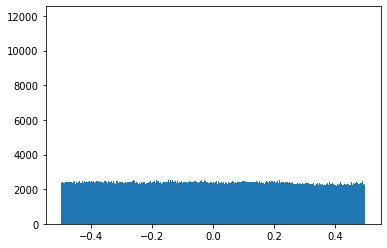

In [9]:
debug_hist([restartdict['SP01'][i][0] for i in range(0,len(restartdict['SP01']))]) #xx?

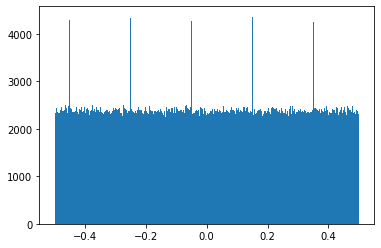

In [10]:
debug_hist([restartdict['SP01'][i][1] for i in range(0,len(restartdict['SP01']))]) #yy?

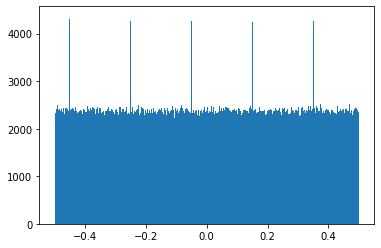

In [11]:
debug_hist([restartdict['SP01'][i][2] for i in range(0,len(restartdict['SP01']))]) #zz?

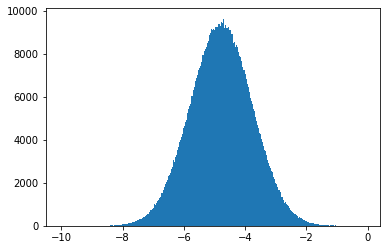

In [12]:
debug_hist([restartdict['SP01'][i][3] for i in range(0,len(restartdict['SP01']))]) #vx

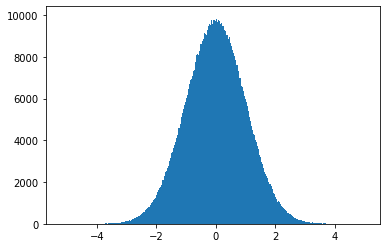

In [13]:
debug_hist([restartdict['SP01'][i][4] for i in range(0,len(restartdict['SP01']))]) #vy

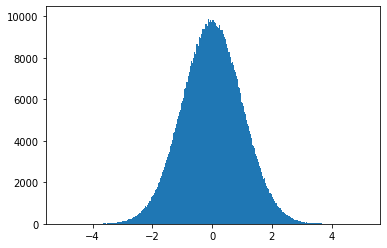

In [14]:
debug_hist([restartdict['SP01'][i][5] for i in range(0,len(restartdict['SP01']))]) #vz

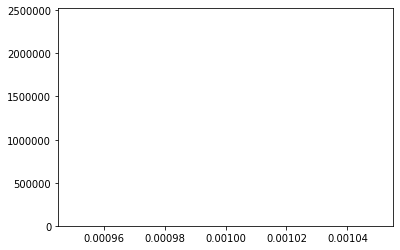

In [15]:
debug_hist([restartdict['SP01'][i][6] for i in range(0,len(restartdict['SP01']))]) #gamma

In [16]:
restartdict['SP01INDEX'].shape

(2402325, 3)

In [17]:
restartdict['SP01TAG1'].shape

(2402325,)

In [18]:
restartdict['SP01TAG2'].shape

(2402325,)

In [21]:
#             pts = f[sp][:]
#             ind = f[sp+'INDEX'][:]
#             pts[:, 0] = pts[:,0] + bcx + dx*(ind[:,0] - 4)
#             pts[:, 1] = pts[:,1] + bcy + dy*(ind[:,1] - 4)
bcx = 50.
bcy = 6.
bcz = 6.
dx = .25
xx = [restartdict['SP01'][i][0]+bcx+dx*(restartdict['SP01INDEX'][i][0]-4) for i in range(0,len(restartdict['SP01']))]

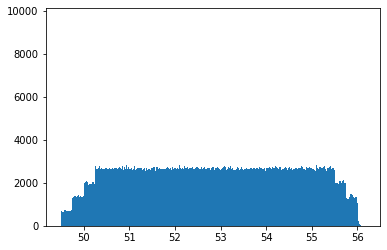

In [22]:
debug_hist(xx)

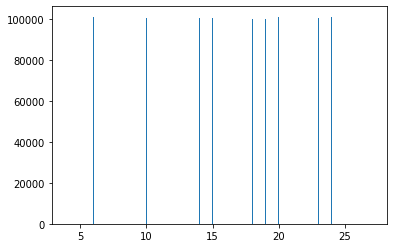

In [115]:
debug_hist([restartdict['SP01INDEX'][i][0] for i in range(0,len(restartdict['SP01']))])

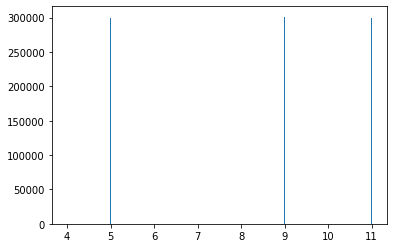

In [116]:
debug_hist([restartdict['SP01INDEX'][i][1] for i in range(0,len(restartdict['SP01']))])

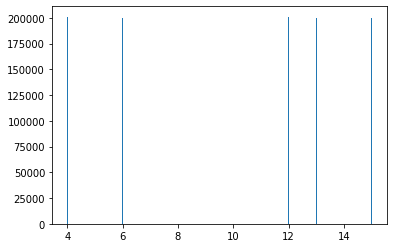

In [117]:
debug_hist([restartdict['SP01INDEX'][i][2] for i in range(0,len(restartdict['SP01']))])

In [50]:
class PartMapper(object):
    def __init__(self, path):
        self.path=path

        self.p = self.read_input(path)

        self.px,self.py,self.pz = self.p['node_number']
        self.nx,self.ny,self.nz = self.p['ncells']
        self.rx,self.ry,self.rz = self.p['boxsize']

        self.dx = self.rx/1./self.nx
        self.dy = self.ry/1./self.ny
        self.dz = self.rz/1./self.nz
        
    def read_input(self,path='./'):
        """Parse dHybrid input file for simulation information

        Args:
            path (str): path of input file
        """
        import os

        path = os.path.join(path, "input/input")
        inputs = {}
        repeated_sections = {}
        # Load in all of the input stuff
        with open(path) as f:
            in_bracs = False
            for line in f:
                # Clean up string
                line = line.strip()

                # Remove comment '!'
                trim_bang = line.find('!')
                if trim_bang > -1:
                    line = line[:trim_bang].strip()

                # Is the line not empty?
                if line:
                    if not in_bracs:
                        in_bracs = True
                        current_key = line

                        # The input has repeated section and keys for differnt species
                        # This section tries to deal with that
                        sp_counter = 1
                        while current_key in inputs:
                            inputs[current_key+"_01"] = inputs[current_key]
                            sp_counter += 1
                            current_key = "{}_{:02d}".format(line, sp_counter)
                            repeated_sections[current_key] = sp_counter

                        inputs[current_key] = []

                    else:
                        if line == '{':
                            continue
                        elif line == '}':
                            in_bracs = False
                        else:
                            inputs[current_key].append(line)

        # Parse the input and cast it into usefull types
        param = {}
        repeated_keys = {}
        for key,inp in inputs.items():
            for sp in inp:
                k = sp.split('=')
                k,v = [v.strip(' , ') for v in k]

                _fk = k.find('(')
                if _fk > 0:
                    k = k[:_fk]

                if k in param:
                    param["{}_{}".format(k, key)] = param[k]
                    k = "{}_{}".format(k, key)

                param[k] = [self._auto_cast(c.strip()) for c in v.split(',')]

                if len(param[k]) == 1:
                    param[k] = param[k][0]

        return param

    def _box_center(self, ip, jp):
        dx = self.dx
        dy = self.dy

        npx = self.nx//self.px
        Mx = (self.nx/1./self.px - npx)*self.px

        npy = self.ny//self.py
        My = (self.ny/1./self.py - npy)*self.py

        if ip < Mx:
            xr = dx*(npx + 1)*ip + dx/2.
        else:
            xr = dx*(Mx + npx*ip) + dx/2.

        if jp < My:
            yr = dy*(npy + 1)*jp + dy/2.
        else:
            yr = dy*(My + npy*jp) + dy/2.

        return xr,yr

    def xrange_to_nums(self, x0, x1):
        i0 = np.int(np.floor(x0/self.rx*self.px))
        i1 = np.int(np.min([np.ceil(x1/self.rx*self.px), self.px - 1]))

        nums = np.arange(i0, i1)
        for _ny in np.arange(1, self.py):
            nums += np.arange(i0 + _ny*self.px, i1 + _ny*self.px)

        return nums

    def _num_to_index(self, num):
        ip = num%self.px
        jp = num//self.px
        return ip,jp

    def _index_to_num(self, ip, jp):
        num = self.px*jp + ip
        return num

    def parts_from_index(self, ip, jp, sp='SP01'):
        fname = self.path+'/Restart/Rest_proc{:05d}.h5'
        num = self._index_to_num(ip, jp)
        bcx,bcy = self._box_center(ip, jp)
        dx,dy = self.dx,self.dy

        with h5py.File(fname.format(num),'r') as f:

            pts = f[sp][:]
            ind = f[sp+'INDEX'][:]
            pts[:, 0] = pts[:,0] + bcx + dx*(ind[:,0] - 4)
            pts[:, 1] = pts[:,1] + bcy + dy*(ind[:,1] - 4)
            pts[:, 2] = pts[:,2] + bcz + dz*(ind[:,2] - 4)

        return pts

    def parts_from_num(self, num, sp='SP01'):
        ip, jp = self._num_to_index(num)
        return self.parts_from_index(ip, jp, sp=sp)
    
    def _auto_cast(self,k):
        """Takes an input string and tries to cast it to a real type

        Args:
            k (str): A string that might be a int, float or bool
        """

        k = k.replace('"','').replace("'",'')

        for try_type in [int, float]:
            try:
                return try_type(k)
            except:
                continue

        if k == '.true.':
            return True
        if k == '.false.':
            return False

        return str(k)

In [55]:
#pathrestart = 'secondrun/Restart/Rest_proc00015.h5'
#pathrestart = 'secondrun'
pathrestart = '/Users/collbrown/Documents/OneDrive - University of Iowa/Research/DHybridR/old/firstbatch/dHybridR/secondrun'
PM = PartMapper(pathrestart)

In [106]:
procs = PM.xrange_to_nums(0., 200000.)

for _c,_p in enumerate(procs):
    pts = PM.parts_from_num(_p)
    _v1,_v2,_v3 = pts[:,2:5].T

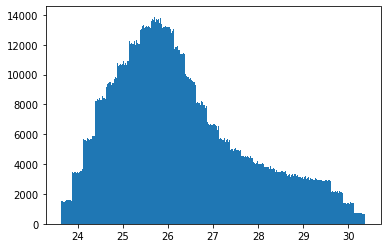

In [107]:
debug_hist([pts[i][0] for i in range(0,len(pts))])

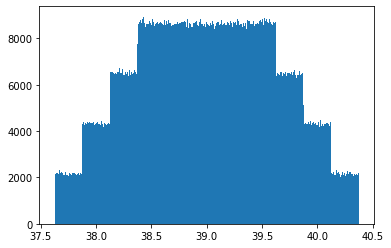

In [108]:
debug_hist([pts[i][1] for i in range(0,len(pts))])

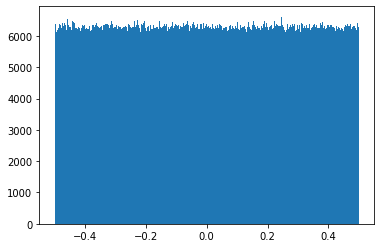

In [109]:
debug_hist([pts[i][2] for i in range(0,len(pts))])

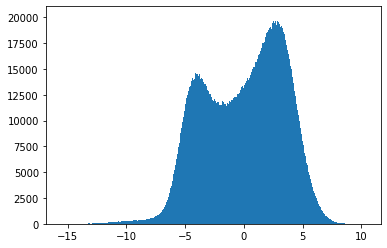

In [110]:
debug_hist([pts[i][3] for i in range(0,len(pts))])

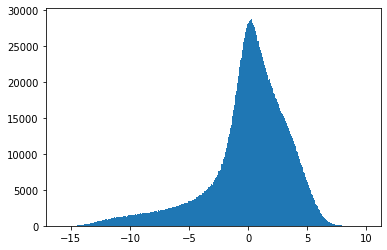

In [111]:
debug_hist([pts[i][4] for i in range(0,len(pts))])

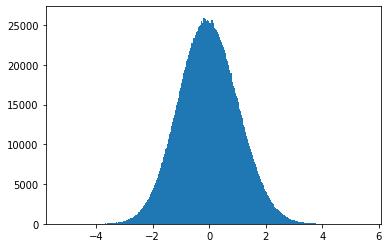

In [112]:
debug_hist([pts[i][5] for i in range(0,len(pts))])

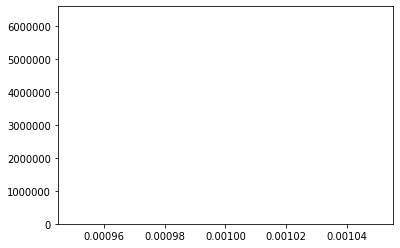

In [113]:
debug_hist([pts[i][6] for i in range(0,len(pts))])

In [121]:
10//3

3